In [59]:
import math
import random
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto()
tf.config.list_physical_devices('GPU')

config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [60]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [61]:
import os
train_dir = f"{os.getcwd()}\\..\\data\\tr"
batch_size = 32
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [62]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [63]:
FILE_NAMES = ['combinedneg.txt', 'combinedneut2.txt', 'combinedpos.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [64]:
BUFFER_SIZE = 50000

In [65]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [66]:
DATASET_SIZE = [i for i,_ in enumerate(all_labeled_data)][-1] + 1
BATCH_SIZE = 32
VALIDATION_SIZE = math.ceil(DATASET_SIZE * 0.1)
VOCAB_SIZE = 45000

In [67]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(1):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'pid\xc3\xa4 k\xc3\xa4dest\xc3\xa4ni kiinni, randy.'
Label: 2


In [68]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [69]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])
encoder = TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
print(len(vocab), vocab[:20])
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

texts:  [b'etk\xc3\xb6 saanut ottaa sit\xc3\xa4 mukaasi?'
 b'niin palmut ja mandoliininsoittajat en\xc3\xa4\xc3\xa4 puuttuvat,'
 b'nokiassa vaalitaan erilaisuutta.']

labels:  [0 1 1]
51668 ['' '[UNK]' 'on' 'ja' 'ei' 'se' 'että' 'ole' 'en' 'kun' 'mutta' 'niin'
 'jos' 'hän' 'olen' 'mitä' 'oli' 'voi' 'nyt' 'kuin']
[[  406   189   216    23  2406     0     0     0     0     0     0     0
      0     0     0]
 [   11 31257     3 35501    68  4221     0     0     0     0     0     0
      0     0     0]
 [12563 19919 15589     0     0     0     0     0     0     0     0     0
      0     0     0]]
Original:  b'etk\xc3\xb6 saanut ottaa sit\xc3\xa4 mukaasi?'
Round-trip:  etkö saanut ottaa sitä mukaasi          

Original:  b'niin palmut ja mandoliininsoittajat en\xc3\xa4\xc3\xa4 puuttuvat,'
Round-trip:  niin palmut ja mandoliininsoittajat enää puuttuvat         

Original:  b'nokiassa vaalitaan erilaisuutta.'
Round-trip:  nokiassa vaalitaan erilaisuutta            



In [70]:
import pickle
with open("..\\data\\others\\vocab2.pickle", "wb") as output_file:
    pickle.dump(vocab, output_file)

In [71]:
def create_model(num_labels):
    model_layers = tf.keras.Sequential([
        encoder,
        layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=False),
        layers.Bidirectional(layers.LSTM(128, dropout=0.1, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
        layers.Dropout(0.10),
        layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.10),
        layers.Dense(num_labels),
        layers.Activation('softmax')])
    return model_layers

In [72]:
model = create_model(num_labels=3)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.compile(
    optimizer=optimizers.Adamax(0.005),
    loss=losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=test_dataset, callbacks=[early_stop], epochs=30)
model.summary()

Epoch 1/30
961/961 [==============================] - 25s 21ms/step - loss: 0.9301 - accuracy: 0.5678 - val_loss: 0.8620 - val_accuracy: 0.6113
Epoch 2/30
961/961 [==============================] - 19s 20ms/step - loss: 0.7655 - accuracy: 0.6909 - val_loss: 0.7926 - val_accuracy: 0.6842
Epoch 3/30
961/961 [==============================] - 20s 20ms/step - loss: 0.5924 - accuracy: 0.7988 - val_loss: 0.7657 - val_accuracy: 0.7045
Epoch 4/30
961/961 [==============================] - 20s 20ms/step - loss: 0.4323 - accuracy: 0.8717 - val_loss: 0.7912 - val_accuracy: 0.7203
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 32)          1653376   
_________________________________________________________________
bidire

In [73]:
model.save(f'model/rnn_{time}')
# model.save(f'model/rnn_{time}.h5')

INFO:tensorflow:Assets written to: model/rnn_09-12-2021_15-33-44\assets


INFO:tensorflow:Assets written to: model/rnn_09-12-2021_15-33-44\assets


In [74]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

107/107 [==============================] - 2s 14ms/step - loss: 0.7912 - accuracy: 0.7203
Test Loss: 0.7912015318870544
Test Accuracy: 0.720269501209259


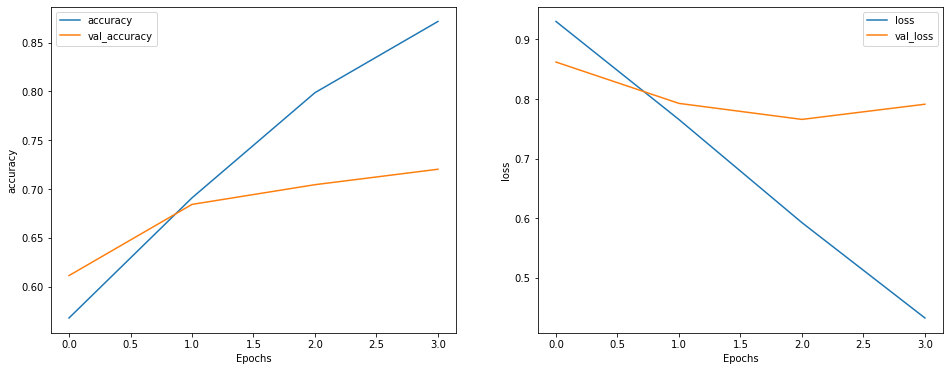

In [75]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [76]:
modelpath = f"model/rnn_{time}"
import_model = tf.keras.models.load_model(modelpath)
import_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 32)          1653376   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         164864    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [77]:
n = 5
inputs = []
with open(f"D:\\Work\\Data\\s24_2001_sentences_shuffled_slice.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
    random.shuffle(lines)
    for line in lines:
        inputs.append(line.strip('\n'))
inputs = np.array(inputs[:n])
print(inputs[:n])

['Parhaiten saat vastauksen kysymykseesi merkkien yhteensopivuudesta, kun teetät tähtikarttojenne vertailun, eli synastrian avulla se selviää!) '
 'Mutta ilmeisesti kuitenkin hyvät ajo-ominaisuudet ovat edelleen tallella! '
 'Ei muuta kuin ovikelloja soittelemaan ja etsimään sitä oikeaa "hänen himast". '
 'Auto on 205 gti 1.6 -86. ' 'Siis aivan alussa. ']


In [78]:
def make_prediction(inps):
    predicted_scores = import_model.predict(np.array(inps))
    predicted_labels = tf.argmax(predicted_scores, axis=1)
    lab, pred = '', ''
    labs, preds = [], []
    for i, (inp, label) in enumerate(zip(inputs, predicted_labels)):
        pred = (', '.join(f'{q:.5f}' for q in predicted_scores[i]))
        lab = label.numpy()
        print(f"Sentence: {inp}")
        print(f"Predicted label: {lab}")
        print(f"Predicted probs: {pred}\n")
        labs.append(lab)
        preds.append(pred)
    return labs, preds

print(np.array(inputs), '\n\n', make_prediction(inputs))

Sentence: Parhaiten saat vastauksen kysymykseesi merkkien yhteensopivuudesta, kun teetät tähtikarttojenne vertailun, eli synastrian avulla se selviää!) 
Predicted label: 1
Predicted probs: 0.00023, 0.96251, 0.03726

Sentence: Mutta ilmeisesti kuitenkin hyvät ajo-ominaisuudet ovat edelleen tallella! 
Predicted label: 1
Predicted probs: 0.00735, 0.63941, 0.35323

Sentence: Ei muuta kuin ovikelloja soittelemaan ja etsimään sitä oikeaa "hänen himast". 
Predicted label: 1
Predicted probs: 0.00042, 0.93207, 0.06752

Sentence: Auto on 205 gti 1.6 -86. 
Predicted label: 1
Predicted probs: 0.05304, 0.92996, 0.01700

Sentence: Siis aivan alussa. 
Predicted label: 1
Predicted probs: 0.06814, 0.91094, 0.02091

['Parhaiten saat vastauksen kysymykseesi merkkien yhteensopivuudesta, kun teetät tähtikarttojenne vertailun, eli synastrian avulla se selviää!) '
 'Mutta ilmeisesti kuitenkin hyvät ajo-ominaisuudet ovat edelleen tallella! '
 'Ei muuta kuin ovikelloja soittelemaan ja etsimään sitä oikeaa "hän